In [8]:
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
import astropy.units as u
from tqdm import tqdm
from popsims.galaxy import Disk, Halo, GalacticComponent
from popsims import sample_from_powerlaw
import popsims
from gala.units import UnitSystem
import pandas as pd
from scipy.interpolate import interp1d, griddata, InterpolatedUnivariateSpline
from astropy.io.votable import parse_single_table
import numba
plot_style()
import warnings
warnings.filterwarnings("ignore")
import glob
%matplotlib inline

In [17]:
path_plot = '/users/caganze/research/stellarstreams/figures/'
path_isochrones = '/users/caganze/research/stellarstreams/data/isochrones/'
path_pandas= '/users/caganze/research/stellarstreams/data/pandas/'

mag_keys=['gmag', 'imag', 'F062mag', 'F087mag']


In [18]:
def read_pandas_isochrones():
    from astropy.io import ascii
    return ascii.read(path_isochrones+'/cfht_pre2014_isochrones.txt').to_pandas()

def read_roman_isochrones():
    from astropy.io import ascii
    return ascii.read(path_isochrones+'/roman_isochrones_vega.txt').to_pandas()

def combined_isochrones():
    from astropy.io import ascii
    fls= glob.glob(path_isochrones+'/*.txt')
    dfs=[]
    for f in fls:
        dfs.append(ascii.read(f).to_pandas())
    comb_isos=pd.concat(dfs).reset_index(drop=True)
    return comb_isos    

def sample_kroupa_imf(nsample, massrange=[0.1, 10]):
    m0=sample_from_powerlaw(-0.3, xmin=0.03, xmax= 0.08, nsample=int(nsample))
    m1=sample_from_powerlaw(-1.3, xmin=0.08, xmax= 0.5,  nsample=int(nsample))
    m2=sample_from_powerlaw(-2.3, xmin=0.5, xmax= 100 , nsample=int(nsample))
    m= np.concatenate([m0, m1, m2]).flatten()
    mask= np.logical_and(m> massrange[0], m< massrange[1])
    masses= np.random.choice(m[mask], int(nsample))
    return masses

def interpolate_isochrones(mass_range, age_range, met_range, nsample):
    
    isos= combined_isochrones()
    logage_range=np.log10(age_range)
    limits=np.concatenate([mass_range, logage_range, met_range])
    
    query='(Mini > {} & Mini <{}) & (logAge > {} & logAge <  {}) & (MH > {} & MH < {})'.format(*limits)
    isos=isos.query(query)

    masses=sample_kroupa_imf(2*nsample, massrange=mass_range)
    
    @numba.jit
    def interpolate_one_iso(masses, age, met):
        dfn=isos.query('logAge=={} & MH=={}'.format(age, met))
        interpolated={}
        for k in mag_keys:
            x= np.log10(dfn.Mini.values)
            y= dfn[k].values
            nans=np.logical_or(np.isnan(x), np.isnan(y))
            interpolated.update({k:griddata(x[~nans], y[~nans], np.log10(masses) , fill_value=np.nan, method='linear', rescale=False)})
        return interpolated
    
    final_df=[]
    for logAge in np.unique(isos.logAge):
        for MH in np.unique(isos.MH):
            vs=pd.DataFrame(interpolate_one_iso(masses, logAge,  MH))
            vs['logAge']=logAge
            vs['MH']=MH
            vs['Mini']=masses
            final_df.append(vs)
    
    return  pd.concat(final_df).sample(int(nsample), replace=True).reset_index(drop=True)

def add_app_magnitudes(vals, ds):
    #add intrinsic scatter of 0.1 magnitude --> varies but simplicity
    for k in mag_keys:
        vals['app'+k]=np.random.normal(vals[k], 0.1)+5*np.log10(ds/10.0)
    return vals


def simulate_milky_way(nsample=1e5):
    #milky way disk
    vals=interpolate_isochrones( (0.1, 120), (0.01e9, 13e9) , (-1,0.5), nsample)
    model=Disk(L=2600, H=350)
    ds=np.concatenate([model.sample_distances(0.1, 770_000, 10000) for x in range(0, 10)])
    ds=np.random.choice(ds, int(nsample))
    vals=add_app_magnitudes(vals, ds)
    
    #miky way thick disk
    vals1=interpolate_isochrones( (0.1, 120), (8e9, 13e9) , (-1,0.5), nsample)
    model=Disk(L=3600, H=900)
    ds=np.concatenate([model.sample_distances(0.1, 770_000, 10000) for x in range(0, 10)])
    ds=np.random.choice(ds, int(nsample))
    vals1=add_app_magnitudes(vals1, ds)
    
    #milky way halo
    vals2=interpolate_isochrones( (0.1, 120), (10e9, 13e9) , (-2.5,-1), nsample)
    model=Halo()
    ds=np.concatenate([model.sample_distances(0.1, 770_000, 10000) for x in range(0, 10)])
    ds=np.random.choice(ds, int(nsample))
    vals2=add_app_magnitudes(vals2, ds)
    
    #combine with relative fraction
    return pd.concat([vals.sample(int(nsample)),
                      vals1.sample(int(0.12*nsample)),
                      vals2.sample(int(0.0025*nsample))]).reset_index(drop=True)
                      

def simulate_M31(d_M31, nsample=1e5):
    #halo 
    model=M31Halo()
    vals=interpolate_isochrones( (0.1, 120), (8e9, 13e9) , (-2.5,0.5), nsample)
    ds=np.concatenate([model.sample_distances(0.1, 200_000, 10000) for x in range(0, 10)])
    ds=np.random.choice(ds, int(nsample))

    l= 2*np.pi*np.random.uniform(0, 1, len(ds))
    b= np.arccos(2*np.random.uniform(0, 1, len(ds))-1)-np.pi/2
    r, z= popsims.galaxy.transform_tocylindrical(l, b, ds)
    
    #add the center for M31
    distances_to_use=d_M31.to(u.pc).value+z
    return add_app_magnitudes(vals,    distances_to_use)
    

class M31Halo(GalacticComponent):
    """
    power-law stellar density for M31's halo by Ibata et al. 2014
    
    """
    def __init__(self, q=1.11, gamma=-3):
        super().__init__({'q': q, 'gamma': gamma})

    def stellar_density(self, r, z):
        """
        Compute the stellar density at a particular position

        Args:
        ----
            x, y, z: galacto-centric x, y,z ( astropy.quantity )
        Returns:
        -------
            unit-less stellar density

        Examples:
        --------
            > d = Disk.stellar_density(100*u.pc, -100*u.pc)
        """
        #add a raise error if r <0
        
        s= (r**2+(z/self.q)**2)**0.5

        return s**self.gamma

In [34]:
d_M31=770*u.kpc
mag_limit=28.69
rgc='10_20'

m31=simulate_M31(d_M31, nsample=5e5)
mw=simulate_milky_way(nsample=1e5)

In [14]:
data=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()

In [41]:
mask_m31=np.logical_and.reduce( [(data.g-data.i) >0. , (data.g-data.i) <0.5,  data.g >22])
mask_mw=np.logical_and.reduce( [(data.g-data.i) >1. , (data.g-data.i) <2,  data.g <20])

#compute the fraction of stars that are in the true data
ndata_m31_bounds=len(data[mask_m31])
ndata_mw_bounds=len(data[mask_mw])

#compute number of stars in sims
m31_small==m31.query('appimag > {} & appimag< {}'.format(*(data.g.min(), data.g.max())))
mw_small=mw.query('appimag > {} & appimag< {}'.format(*(data.g.min(), data.g.max())))

#compute the fraction of simulated stars within these bounds
nsim_m31_bounds=len(m31_small[np.logical_and.reduce( [(m31_small.gmag-m31_small.imag) >0. , (m31_small.gmag-m31_small.imag) <0.5, m31_small.gmag >22])])
mask_mw_bounds=len(mw_small[np.logical_and.reduce( [(mw_small.gmag-mw_small.imag) >1. , (mw_small.gmag-mw_small.imag) <2,  mw_small.gmag <20])])

#compute the fraction of stars that we need to simulate
print ('currrent number of M31 stars within g-i of [0.,0.5] in data {}'.format(ndata_m31_bounds))
print ('currrent number of M31 stars within g-i of [0.,0.5] in simulation {}'.format(nsim_m31_bounds))
#re-simulate (not great for time saving )


#verify that we have reached the target number of stars within the bins


#make roman cuts 


currrent number of M31 stars within g-i of [0.,0.5] in data 9708
currrent number of M31 stars within g-i of [0.,0.5] in simulation 0


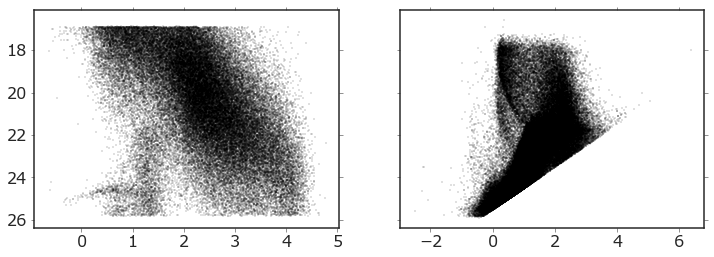

In [52]:
fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
ax.scatter(m31_small.appgmag-m31_small.appimag, m31_small.appimag, s=1, marker=',', alpha=0.1, color='k')
ax.scatter(mw_small.appgmag-mw_small.appimag, mw_small.appimag, s=1, marker=',', alpha=0.1, color='k')


ax1.scatter(data.g0-data.i, data.i,  s=1, marker=',', alpha=0.1, color='k')
ax1.invert_yaxis()

In [ ]:
#what is the number of stars in each image 